In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from keras.models import load_model
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import shap
from scipy.stats import pearsonr
import sys
sys.path.insert(0, '/Users/huripari/Documents/PhD/TCs_Genesis/FS_TCG')
import utils_results as ut

In [2]:
basin = 'GLB'
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')

2025-02-25 14:07:34.582250: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-02-25 14:07:34.582280: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-02-25 14:07:34.582284: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-02-25 14:07:34.582315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-25 14:07:34.582329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-25 14:07:34.956355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


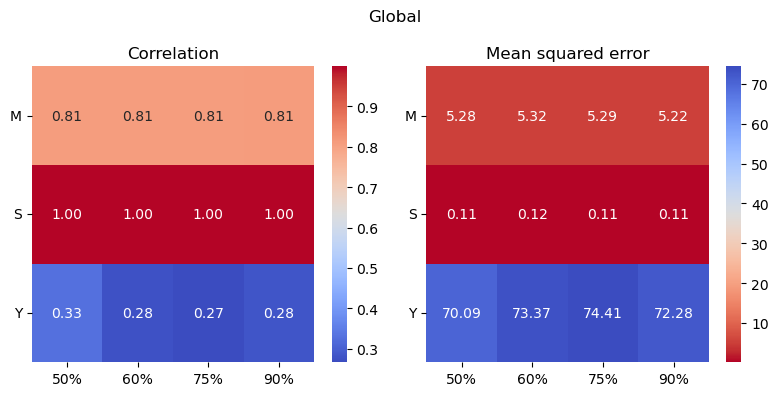

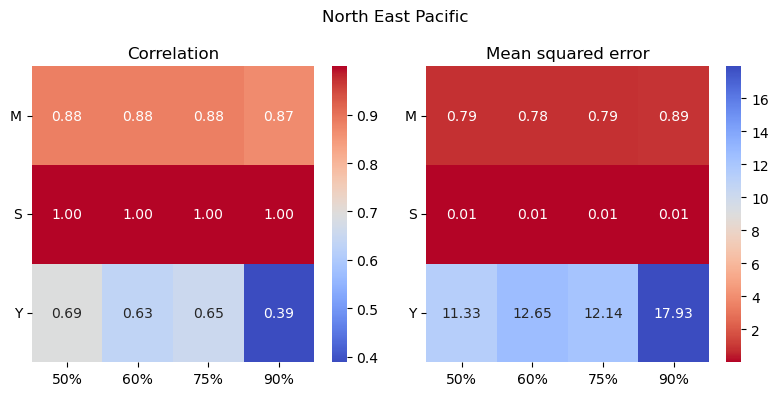

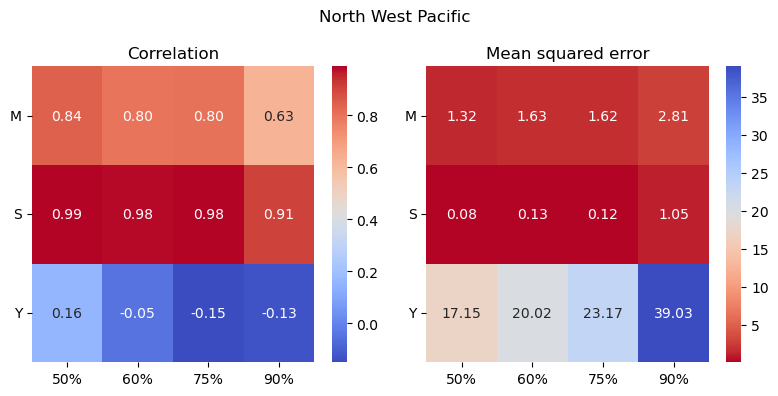

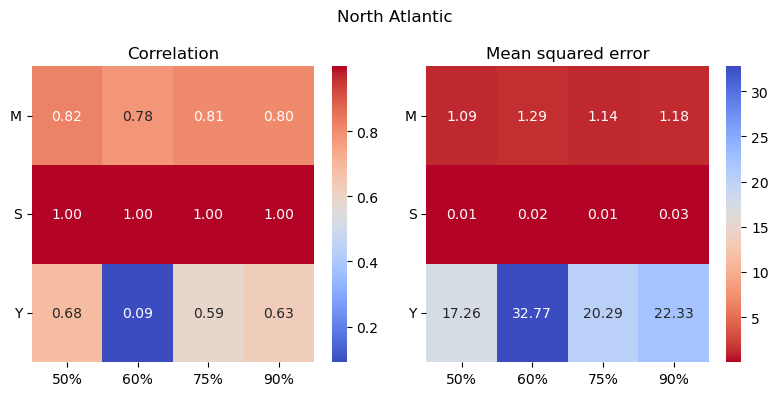

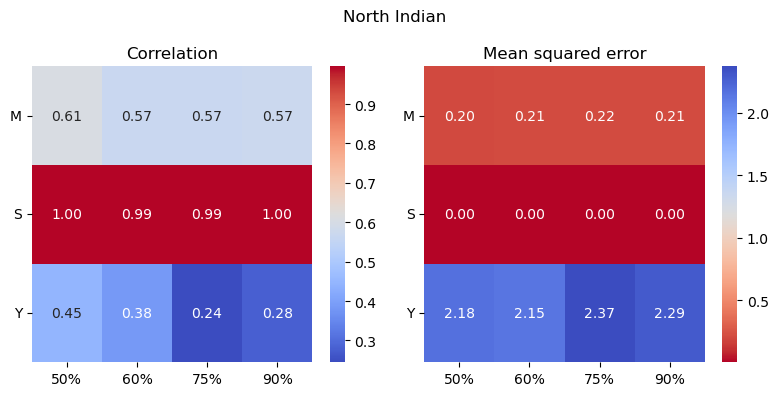

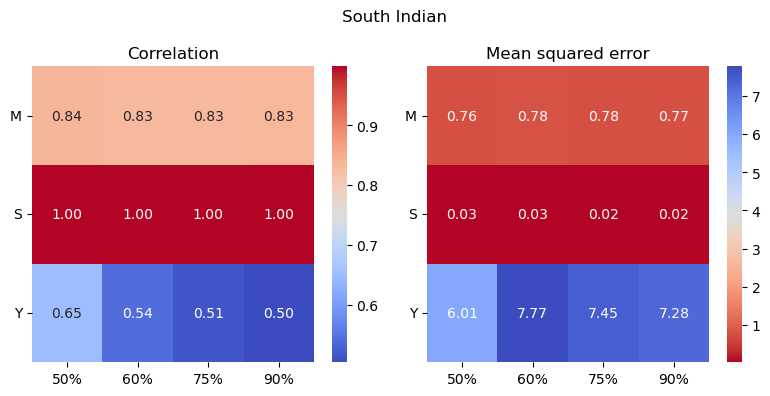

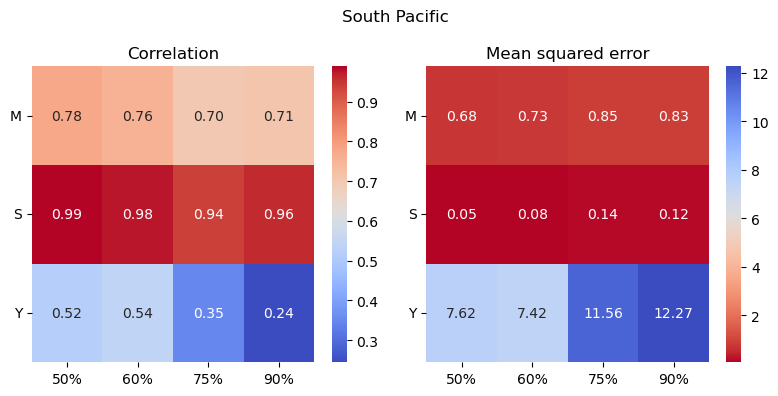

In [ ]:
basin_dict = {'GLB': ('Global', 'nc12'), 'NEP': ('North East Pacific', 'DSnc12'), 'NWP': ('North West Pacific', 'Anc10'), 'NA': ('North Atlantic', 'DSnc6'),
              'NI': ('North Indian', 'DSnc12'), 'SI': ('South Indian', 'DSnc9'), 'SP': ('South Pacific', 'nc7')}
for basin, (basin_name, cldt) in basin_dict.items():
    run_names = [f'selfeat50_top20_{cldt}_nv8_nd9', f'selfeat60_top20_{cldt}_nv8_nd9', f'selfeat70_top20_{cldt}_nv8_nd9', f'selfeat90_top20_{cldt}_nv8_nd9'
                 f'selfeat80_top20_{cldt}_nv8_nd9', f'selfeat90_top20_{cldt}_nv8_nd9']
    col_perc = [run.split('_')[0].split('feat')[1] for run in run_names]
    df_corr = pd.DataFrame(0.0, index=['rM', 'rS', 'rY'], columns=col_perc)
    df_mse = pd.DataFrame(0.0, index=['mseM', 'mseS', 'mseY'], columns=col_perc)
    for run_name in run_names:
        # Get the run info and data
        try:
            dataset_opt, dataset_opt_noFS, Y_pred, Y_pred_noFS, Y_test, X_test_eval, X_test_eval_noFS, mlps, mlps_noFS, perm_importance_mlp, perm_importance_mlp_noFS, shap_values_mlp, shap_values_mlp_noFS = ut.runs_info(basin, run_name)
        except:
            print(f'Error for {basin} - {run_name}')
        X_test = pd.concat(X_test_eval)
        X_test_noFS = pd.concat(X_test_eval_noFS)
        # Concat the predictions and the test values
        Y_pred_df = pd.concat(Y_pred)
        Y_test_df = pd.concat(Y_test)
        Y_pred_noFS_df = pd.concat(Y_pred_noFS)
        # If the data used are deseasonalized, then the predictions should be deseasonalized as well
        if 'DS' in cldt:
            n_clusters = int(cldt.split('nc')[1].split('_')[0])
            cluster_data = cluster_data = f'{basin}_{n_clusters}clusters_deseason'
            data_dir = os.path.join(fs_dir, 'data', cluster_data)
            target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
            target_season_df = pd.read_csv(os.path.join(data_dir, target_season), index_col=0)
            target_season_df.index = pd.to_datetime(target_season_df.index)
            Y_pred_df['tcg'] = Y_pred_df['tcg'] + target_season_df.loc[Y_pred_df.index, 'seasonal']
            Y_test_df = Y_test_df + target_season_df.loc[Y_test_df.index, 'seasonal']
            Y_pred_noFS_df['tcg'] = Y_pred_noFS_df['tcg'] + target_season_df.loc[Y_pred_noFS_df.index, 'seasonal']
        # values smaller than 0 are set to 0
        Y_pred_df.loc[Y_pred_df['tcg'] < 0, 'tcg'] = 0.0
        Y_pred_noFS_df.loc[Y_pred_noFS_df['tcg'] < 0, 'tcg'] = 0.0
        # Compute seasonal mean values
        Y_pred_df_season = Y_pred_df.groupby(Y_pred_df.index.month).mean()
        Y_test_df_season = Y_test_df.groupby(Y_test_df.index.month).mean()
        Y_pred_noFS_df_season = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.month).mean()
        # Compute annual cumulative values
        Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
        Y_test_df_annual = Y_test_df.groupby(Y_test_df.index.year).sum()
        Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
        # Compute the correlation coefficient and the MSE between the predictions and the test values
        # Monthly
        r, _ = pearsonr(Y_test_df, Y_pred_df['tcg'])
        mse = mean_squared_error(Y_test_df, Y_pred_df['tcg'])
        r_noFS, _ = pearsonr(Y_test_df, Y_pred_noFS_df['tcg'])
        mse_noFS = mean_squared_error(Y_test_df, Y_pred_noFS_df['tcg'])
        # Seasonal
        rS, _ = pearsonr(Y_test_df_season, Y_pred_df_season['tcg'])
        mseS = mean_squared_error(Y_test_df_season, Y_pred_df_season['tcg'])
        rS_noFS, _ = pearsonr(Y_test_df_season, Y_pred_noFS_df_season['tcg'])
        mseS_noFS = mean_squared_error(Y_test_df_season, Y_pred_noFS_df_season['tcg'])
        # Annual
        rY, _ = pearsonr(Y_test_df_annual, Y_pred_df_annual['tcg'])
        mseY = mean_squared_error(Y_test_df_annual, Y_pred_df_annual['tcg'])
        rY_noFS, _ = pearsonr(Y_test_df_annual, Y_pred_noFS_df_annual['tcg'])
        mseY_noFS = mean_squared_error(Y_test_df_annual, Y_pred_noFS_df_annual['tcg'])
        # Store the results
        perc = run_name.split('_')[0].split('feat')[1]
        df_corr.loc['rM', perc] = r
        df_corr.loc['rS', perc] = rS
        df_corr.loc['rY', perc] = rY
        df_mse.loc['mseM', perc] = mse
        df_mse.loc['mseS', perc] = mseS
        df_mse.loc['mseY', perc] = mseY
    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax[0])
    ax[0].set_title('Correlation')
    sns.heatmap(df_mse, annot=True, fmt=".2f", cmap='coolwarm_r', ax=ax[1])
    ax[1].set_title('Mean squared error')
    xtick_labels = ['50%', '60%', '75%', '90%']
    for a in ax:
        a.set_xticks(np.arange(len(xtick_labels), dtype=float)+0.5)
        a.set_xticklabels(xtick_labels)
        a.set_yticks(np.arange(3, dtype=float)+0.5)
        a.set_yticklabels(['M', 'S', 'Y'], rotation=0)
    fig.suptitle(f'{basin_name}')
    plt.tight_layout()
plt.show()